In [1]:
import gymnasium
import matplotlib.pyplot as plt
import torch as th
import numpy as np

from DQN_model import DQNModel
from ModelWithTemperature import ModelWithTemperature
from gymnasium.wrappers import AtariPreprocessing, FrameStack

import warnings
warnings.filterwarnings('ignore')

/home/e.piccoli/.pyenv/versions/3.8.10/envs/skill-rl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
DATA_PATH = "./logs/run5"
DATASET = "Atari"
MODEL_NAME = "NatureDQNNetwork"
NUM_EXPERIENCES = 5
GAMES_AVAILABLE = ['VideoPinball', 'Boxing', 'Breakout', 'StarGunner', 'Atlantis']
FULL_ACTION_SPACE = 18
NUM_RUNS = 1
DEVICE = "cuda:3"

In [3]:
# all combinations of training
run2name = {
    "n_nst_npp" : "Naive_NoSelfTraining_NoPostProcessing",
    "n_st_npp" : "Naive_SelfTraining_NoPostProcessing",
    "n_nst_pp" : "Naive_NoSelfTraining_PostProcessing",
    "n_nst_pp_md" : "Naive_NoSelfTraining_PostProcessing_MixedData",

    "r_nst_npp" : "Replay_NoSelfTraining_NoPostProcessing",
    "r_st_npp" : "Replay_SelfTraining_NoPostProcessing",
    "r_nst_pp" : "Replay_NoSelfTraining_PostProcessing",
    "r_nst_pp_md" : "Replay_NoSelfTraining_PostProcessing_MixedData",
    
    "j" : "JointTraining",
}

In [4]:
run2label = {
    "n_nst_npp" : "Naive",
    "n_st_npp" : "Naive_SelfTraining",
    "n_nst_pp" : "Naive_PostProcessing",
    "n_nst_pp_md" : "Naive_PostProcessing_MixedData",

    "r_nst_npp" : "Replay",
    "r_st_npp" : "Replay_SelfTraining",
    "r_nst_pp" : "Replay_PostProcessing",
    "r_nst_pp_md" : "Replay_PostProcessing_MixedData",
    
    "j" : "JointTraining",
}

In [7]:
reward_current_exp = []

for name, exp_setting in run2name.items():
    print(f">> {exp_setting} <<")
    for j, game in enumerate(GAMES_AVAILABLE):
        model_path = f"{DATA_PATH}/model_{exp_setting}.pt" if name == "j" else f"{DATA_PATH}/model_{exp_setting}_exp{j}.pt"
        print("> Loading Model:", model_path)
        model = DQNModel(FULL_ACTION_SPACE)
        if "_PostProcessing" in exp_setting:
            mt = ModelWithTemperature(model, DEVICE)
            mt.load_state_dict(th.load(model_path, map_location=DEVICE))
            model = mt.model
        model.eval()

        game_path = f"ALE/{GAMES_AVAILABLE[j]}-v5"
        print("> Creating game:", game_path)
        env = gymnasium.make(game_path, render_mode="rgb_array", full_action_space=True)
        env = AtariPreprocessing(env, frame_skip=1)
        env = FrameStack(env, 4)

        # evaluate on the environment
        avg_reward = 0
        for r in range(NUM_RUNS):
            obs, _ = env.reset()
            done = False
            ep_reward = 0
            ep_steps = 0
            while not done:
                with th.no_grad():
                    action = np.argmax(model(th.unsqueeze(th.from_numpy(np.array(obs)), 0)))
                obs, reward, terminated, truncated, info = env.step(action)
                ep_reward += np.clip(reward, -1, 1)
                # print(f"step: {ep_steps} - action: {action} - reward: {reward} - cumulative_reward: {ep_reward} - done: {terminated or truncated}")
                done = terminated or truncated
                ep_steps += 1
            avg_reward += ep_reward
        avg_reward /= NUM_RUNS
        reward_current_exp.append((name, game, avg_reward))
        env.close()
    print("-----------")

>> Naive_NoSelfTraining_NoPostProcessing <<
> Loading Model: ./logs/run5/model_Naive_NoSelfTraining_NoPostProcessing_exp0.pt
> Creating game: ALE/VideoPinball-v5
> Loading Model: ./logs/run5/model_Naive_NoSelfTraining_NoPostProcessing_exp1.pt
> Creating game: ALE/Boxing-v5
> Loading Model: ./logs/run5/model_Naive_NoSelfTraining_NoPostProcessing_exp2.pt
> Creating game: ALE/Breakout-v5
> Loading Model: ./logs/run5/model_Naive_NoSelfTraining_NoPostProcessing_exp3.pt
> Creating game: ALE/StarGunner-v5
> Loading Model: ./logs/run5/model_Naive_NoSelfTraining_NoPostProcessing_exp4.pt
> Creating game: ALE/Atlantis-v5
-----------
>> Naive_SelfTraining_NoPostProcessing <<
> Loading Model: ./logs/run5/model_Naive_SelfTraining_NoPostProcessing_exp0.pt
> Creating game: ALE/VideoPinball-v5
> Loading Model: ./logs/run5/model_Naive_SelfTraining_NoPostProcessing_exp1.pt
> Creating game: ALE/Boxing-v5
> Loading Model: ./logs/run5/model_Naive_SelfTraining_NoPostProcessing_exp2.pt
> Creating game: ALE/Br

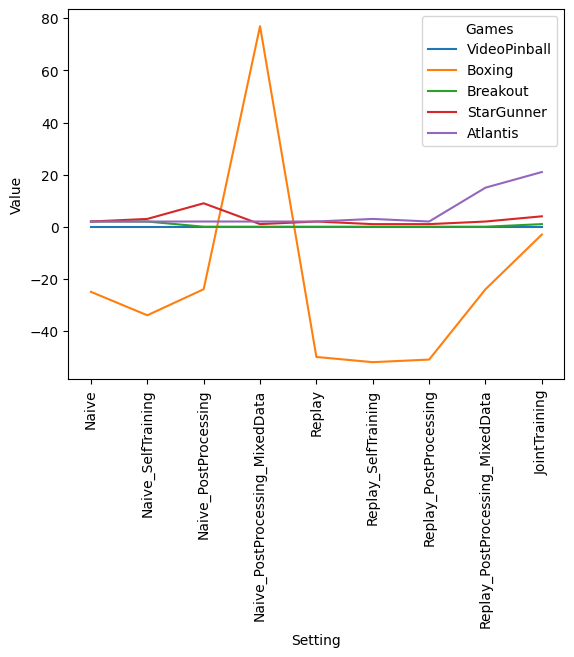

In [9]:
games = {}
players = [run2label[r] for r in run2name.keys()]
for _, game, value in reward_current_exp:
    if game not in games:
        games[game] = []
    games[game].append((_, value))

# Plotting
for game, values in games.items():
    _, scores = zip(*values)
    plt.plot(players, scores, label=game)

# Adding labels and legend
plt.xlabel('Setting')
plt.ylabel('Value')
plt.legend(title='Games')
plt.xticks(rotation=90)

# Show the plot
plt.show()

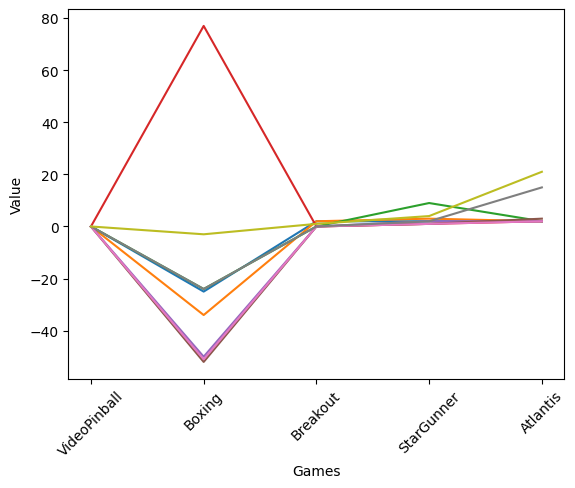

In [19]:
# Extract unique players and corresponding values for each player
players = {}
games = GAMES_AVAILABLE
for player, game, value in reward_current_exp:
    if player not in players:
        players[player] = []
    players[player].append((_, value))

# Plotting
for player, values in players.items():
    
    _, scores = zip(*values)
    plt.plot(games, scores, label=run2label[player])

# Adding labels and legend
plt.xlabel('Games')
plt.ylabel('Value')
# plt.legend(loc='lower right', fontsize='small', ncol=1)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [20]:
reward_current_exp

[('n_nst_npp', 'VideoPinball', 0.0),
 ('n_nst_npp', 'Boxing', -25.0),
 ('n_nst_npp', 'Breakout', 2.0),
 ('n_nst_npp', 'StarGunner', 2.0),
 ('n_nst_npp', 'Atlantis', 2.0),
 ('n_st_npp', 'VideoPinball', 0.0),
 ('n_st_npp', 'Boxing', -34.0),
 ('n_st_npp', 'Breakout', 2.0),
 ('n_st_npp', 'StarGunner', 3.0),
 ('n_st_npp', 'Atlantis', 2.0),
 ('n_nst_pp', 'VideoPinball', 0.0),
 ('n_nst_pp', 'Boxing', -24.0),
 ('n_nst_pp', 'Breakout', 0.0),
 ('n_nst_pp', 'StarGunner', 9.0),
 ('n_nst_pp', 'Atlantis', 2.0),
 ('n_nst_pp_md', 'VideoPinball', 0.0),
 ('n_nst_pp_md', 'Boxing', 77.0),
 ('n_nst_pp_md', 'Breakout', 0.0),
 ('n_nst_pp_md', 'StarGunner', 1.0),
 ('n_nst_pp_md', 'Atlantis', 2.0),
 ('r_nst_npp', 'VideoPinball', 0.0),
 ('r_nst_npp', 'Boxing', -50.0),
 ('r_nst_npp', 'Breakout', 0.0),
 ('r_nst_npp', 'StarGunner', 2.0),
 ('r_nst_npp', 'Atlantis', 2.0),
 ('r_st_npp', 'VideoPinball', 0.0),
 ('r_st_npp', 'Boxing', -52.0),
 ('r_st_npp', 'Breakout', 0.0),
 ('r_st_npp', 'StarGunner', 1.0),
 ('r_st_npp'